* Bibliotecas:

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split,  ShuffleSplit, KFold, cross_validate
from sklearn.svm import SVR

* Leitura dos dados:

In [232]:
dados = pd.read_csv('teste_atualizado.csv')

In [233]:
dados_dicionario = pd.read_csv('dicionario.csv')

In [234]:
dados = dados.sample(frac=0.5, random_state=42)  # Pegar 50% dos dados

In [235]:
dados = dados.drop(columns=['ultima_review','latitude','longitude','host_id','id','bairro'])


In [236]:
for col in ['nome', 'host_name']:
    freq = dados[col].value_counts(normalize=True)
    dados[col] = dados[col].apply(lambda x: x if freq[x] > 0.01 else "Outros")

In [237]:
valores_para_remover = ['ultima_review','latitude','longitude','host_id','id','bairro']
dados_dicionario = dados_dicionario[~dados_dicionario['variavel'].isin(valores_para_remover)]

In [238]:
dados.head(20)

,nome,host_name,bairro_group,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
879,Outros,Outros,Manhattan,Private room,110,3,47,0.57,1,248
47429,Outros,Outros,Brooklyn,Private room,40,1,1,1.00,2,151
15394,Outros,Outros,Brooklyn,Private room,57,3,33,0.85,3,345
24100,Outros,Outros,Brooklyn,Entire home/apt,375,2,14,0.60,1,75
16332,Outros,Outros,Queens,Private room,195,4,0,0.72,1,0
5966,Outros,Outros,Manhattan,Private room,120,14,14,0.24,2,0
34363,Outros,Outros,Brooklyn,Entire home/apt,89,2,14,1.48,2,180
41763,Outros,Outros,Queens,Entire home/apt,60,30,0,0.72,1,121
11118,Outros,Outros,Brooklyn,Entire home/apt,120,30,143,3.17,1,221
22878,Outros,Outros,Queens,Entire home/apt,120,3,3,0.12,1,0


In [239]:
dados.info(20)

<class 'pandas.core.frame.DataFrame'>
Index: 24447 entries, 879 to 5214
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nome                           24447 non-null  object 
 1   host_name                      24447 non-null  object 
 2   bairro_group                   24447 non-null  object 
 3   room_type                      24447 non-null  object 
 4   price                          24447 non-null  int64  
 5   minimo_noites                  24447 non-null  int64  
 6   numero_de_reviews              24447 non-null  int64  
 7   reviews_por_mes                24447 non-null  float64
 8   calculado_host_listings_count  24447 non-null  int64  
 9   disponibilidade_365            24447 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 2.1+ MB


In [240]:
dados_dicionario.head(20)

,variavel,descricao,tipo,subtipo
1,nome,Título do anúncio,qualitativa,nominal
3,host_name,nome do anfitrião,qualitativa,nominal
4,bairro_group,grupo ou região do bairro onde o imóvel está l...,qualitativa,nominal
8,room_type,Tipo de acomodação,qualitativa,nominal
9,price,Preço por noite em dólares,quantitativa,contínua
10,minimo_noites,Número mínimo de noites exigido para reserva,quantitativa,discreta
11,numero_de_reviews,Número total de avaliações do anúncio,quantitativa,discreta
13,reviews_por_mes,Média de avaliações recebidas por mês,quantitativa,contínua
14,calculado_host_listings_count,quantidade de anúncios ativos do anfitrião,quantitativa,discreta
15,disponibilidade_365,Número de dias disponíveis para reserva no ano,quantitativa,discreta


* Estruturação das variáveis:

ordinal_variables = (
    dados_dicionario.query("subtipo == 'ordinal' and variavel != @target_variable").variavel.to_list()
)

print("Variáveis Ordinais:", ordinal_variables)


ordinal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')),
    ("encoding", OrdinalEncoder()),
])

In [241]:
target_variable = 'price'

useless_variables = (
    dados_dicionario.query("tipo == 'inútil'").variavel.to_list()
)

nominal_variables = (
    dados_dicionario.query("subtipo == 'nominal' and variavel != @target_variable").variavel.to_list()
)

continuous_variables = (
    dados_dicionario.query("subtipo == 'contínua' and variavel != @target_variable").variavel.to_list()
)

discrete_variables = (
    dados_dicionario.query("subtipo == 'discreta' and variavel != @target_variable").variavel.to_list()
)

In [242]:
print("Variáveis Nominais:", nominal_variables)
print("Variáveis Contínuas:", continuous_variables)
print("Variáveis Discretas:", discrete_variables)


Variáveis Nominais: ['nome', 'host_name', 'bairro_group', 'room_type']
Variáveis Contínuas: ['reviews_por_mes']
Variáveis Discretas: ['minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count', 'disponibilidade_365']


* Separando X (Variáveis Explicativas) e Y(Variável-alvo)

In [243]:
X = dados.drop(columns=[target_variable] + useless_variables)
y = dados[target_variable]

In [244]:
print("\nX (features):\n", X)


X (features):
          nome host_name bairro_group        room_type  minimo_noites  \
879    Outros    Outros    Manhattan     Private room              3   
47429  Outros    Outros     Brooklyn     Private room              1   
15394  Outros    Outros     Brooklyn     Private room              3   
24100  Outros    Outros     Brooklyn  Entire home/apt              2   
16332  Outros    Outros       Queens     Private room              4   
...       ...       ...          ...              ...            ...   
5512   Outros    Outros    Manhattan  Entire home/apt              3   
5156   Outros    Outros    Manhattan  Entire home/apt              2   
38161  Outros    Outros     Brooklyn     Private room              3   
48120  Outros    Outros    Manhattan  Entire home/apt              1   
5214   Outros    Outros     Brooklyn  Entire home/apt              7   

       numero_de_reviews  reviews_por_mes  calculado_host_listings_count  \
879                   47             0.57  

In [245]:
print("\ny (target):\n", y)


y (target):
 879      110
47429     40
15394     57
24100    375
16332    195
        ... 
5512     226
5156     129
38161     90
48120    175
5214     200
Name: price, Length: 24447, dtype: int64


* Pipeline de Pré-Processamento:

In [246]:
nominal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')),
    ("encoding", OneHotEncoder(sparse_output=True, handle_unknown='ignore')),
])

continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')),
    ("normalization", StandardScaler()),
])

discrete_preprocessor = Pipeline(steps=[
    ("missing", KNNImputer()),
    ("normalization", StandardScaler()),
])


* Aplicando o Pipeline:

In [247]:
nominal_features = ['nome', 'host_name', 'bairro_group', 'room_type']
continuous_features = ['reviews_por_mes']
discrete_features = ['minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count', 'disponibilidade_365']

In [248]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_preprocessor, nominal_features),
        ('continuous', continuous_preprocessor, continuous_features),
        ('discrete', discrete_preprocessor, discrete_features),
    ], sparse_threshold=1.0
)

* Aplicando Preprocessor:

In [249]:
X_preprocessed = preprocessor.fit_transform(X)

In [250]:
print("Dados pré-processados:")
print(X_preprocessed)

Dados pré-processados:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 220023 stored elements and shape (24447, 15)>
  Coords	Values
  (0, 0)	1.0
  (0, 1)	1.0
  (0, 4)	1.0
  (0, 8)	1.0
  (0, 10)	-0.44090909078971907
  (0, 11)	-0.20196365936988625
  (0, 12)	0.5290908677766379
  (0, 13)	-0.18791249140538938
  (0, 14)	1.0228838500950435
  (1, 0)	1.0
  (1, 1)	1.0
  (1, 3)	1.0
  (1, 8)	1.0
  (1, 10)	-0.15777994017854818
  (1, 11)	-0.30291967913444945
  (1, 12)	-0.49536979599046427
  (1, 13)	-0.15793502605651955
  (1, 14)	0.28675879027106943
  (2, 0)	1.0
  (2, 1)	1.0
  (2, 3)	1.0
  (2, 8)	1.0
  (2, 10)	-0.2565459229498869
  (2, 11)	-0.20196365936988625
  (2, 12)	0.2172984918475199
  :	:
  (24444, 3)	1.0
  (24444, 8)	1.0
  (24444, 10)	2.179681652076467
  (24444, 11)	-0.20196365936988625
  (24444, 12)	-0.29493184003603123
  (24444, 13)	-0.18791249140538938
  (24444, 14)	-0.27482115227505505
  (24445, 0)	1.0
  (24445, 1)	1.0
  (24445, 4)	1.0
  (24445, 7)	1.0
  (24445, 10)	-0.15777

## Comparação de Modelos de Regressão

In [61]:
#odelos = [DecisionTreeRegressor(random_state=42), LinearRegression(), KNeighborsRegressor(n_neighbors=5), RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42)] / ,'explained_variance','max_error'

In [251]:
modelos =  [DummyRegressor(strategy='mean'), LinearRegression(), KNeighborsRegressor(n_neighbors=5)]

In [252]:
metricas = ['neg_mean_absolute_error','neg_mean_squared_error','neg_mean_absolute_percentage_error','r2']

In [253]:
monte_carlo = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

In [254]:
results_total = None
for model in modelos:
    model_name = model.__class__.__name__
    print(f"rodando para o modelo: {model_name}")
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model),
    ])

    scores = cross_validate(
        approach, X, y,
        scoring=metricas, 
        cv=monte_carlo
    )
    results_model = pd.DataFrame(scores)
    results_model['model'] = model_name
    if results_total is None:
        results_total = results_model
    else:
        results_total = pd.concat([results_total, results_model])

rodando para o modelo: DummyRegressor
rodando para o modelo: LinearRegression
rodando para o modelo: KNeighborsRegressor


In [255]:
results_total.groupby('model').agg(['mean', 'std']).T

model                                         DummyRegressor  \
fit_time                                mean    3.273678e-02   
                                        std     7.225425e-03   
score_time                              mean    9.790468e-03   
                                        std     5.676882e-03   
test_neg_mean_absolute_error            mean   -9.343058e+01   
                                        std     2.874645e+00   
test_neg_mean_squared_error             mean   -6.400150e+04   
                                        std     2.254130e+04   
test_neg_mean_absolute_percentage_error mean   -7.021470e+13   
                                        std     9.947367e+13   
test_r2                                 mean   -3.477875e-04   
                                        std     3.220057e-04   

model                                         KNeighborsRegressor  \
fit_time                                mean         3.677142e-02   
                                        std          4.862314e-03   
score_time                              mean         2.932786e+00   
                                        std          2.194470e-01   
test_neg_mean_absolute_error            mean        -7.740004e+01   
                                        std          3.531553e+00   
test_neg_mean_squared_error             mean        -6.153328e+04   
                                        std          2.119800e+04   
test_neg_mean_absolute_percentage_error mean        -4.369136e+13   
                                        std          1.023247e+14   
test_r2                                 mean         3.178561e-02   
                                        std          8.313344e-02   

model                                         LinearRegression  
fit_time                                mean      4.875648e-02  
                                        std       7.046683e-03  
score_time                              mean      1.091447e-02  
                                        std       6.198709e-03  
test_neg_mean_absolute_error            mean     -7.489065e+01  
                                        std       3.033343e+00  
test_neg_mean_squared_error             mean     -5.881708e+04  
                                        std       2.235338e+04  
test_neg_mean_absolute_percentage_error mean     -3.725787e+13  
                                        std       6.983836e+13  
test_r2                                 mean      8.943874e-02  
                                        std       3.071850e-02

* Visualizações Gráficas:

In [256]:
results_pivot = results_total.pivot_table(index='model', aggfunc=['mean', 'std'])
results_pivot.columns = ['_'.join(col).strip() for col in results_pivot.columns]
results_pivot = results_pivot.reset_index()

* Boxplot dos Tempos de Treinamento e Previsão

C:\Users\micae\AppData\Local\Temp\ipykernel_14760\3118623084.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_total, x='model', y='fit_time', palette='Purples')
C:\Users\micae\AppData\Local\Temp\ipykernel_14760\3118623084.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_total, x='model', y='score_time', palette='Purples')


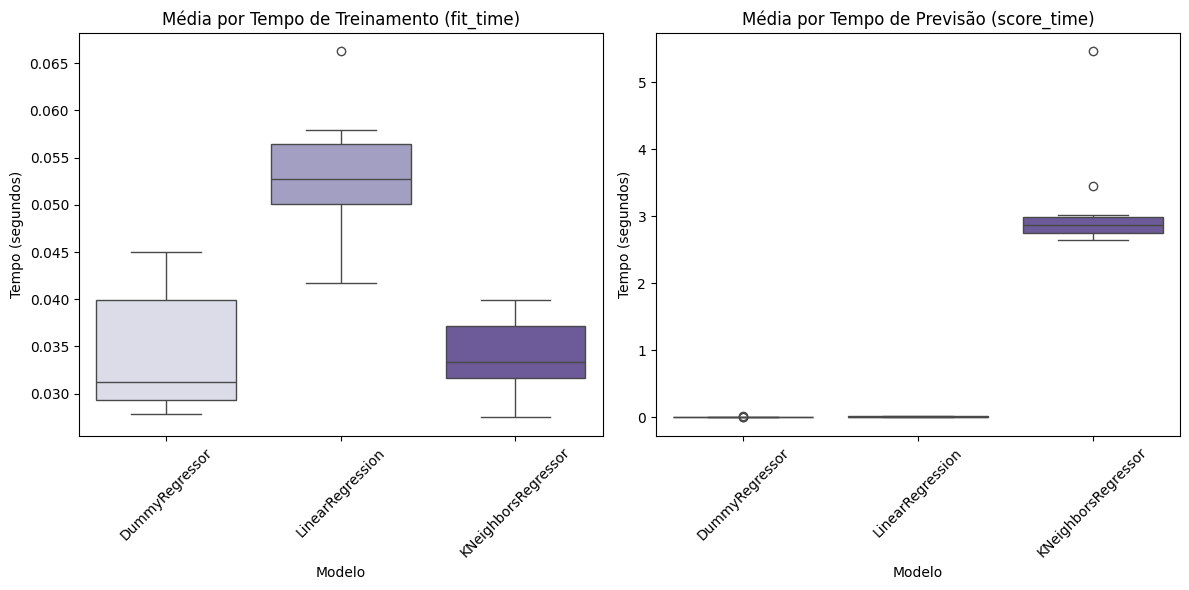

In [190]:
plt.figure(figsize=(12, 6))

# Tempo de treinamento (fit_time)
plt.subplot(1, 2, 1)
sns.boxplot(data=results_total, x='model', y='fit_time', palette='Purples')
plt.title('Média por Tempo de Treinamento (fit_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

# Tempo de previsão (score_time)
plt.subplot(1, 2, 2)
sns.boxplot(data=results_total, x='model', y='score_time', palette='Purples')
plt.title('Média por Tempo de Previsão (score_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

C:\Users\micae\AppData\Local\Temp\ipykernel_14760\1879813264.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=std_results, x='model', y='fit_time', palette='Purples')
C:\Users\micae\AppData\Local\Temp\ipykernel_14760\1879813264.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=std_results, x='model', y='score_time', palette='Purples')


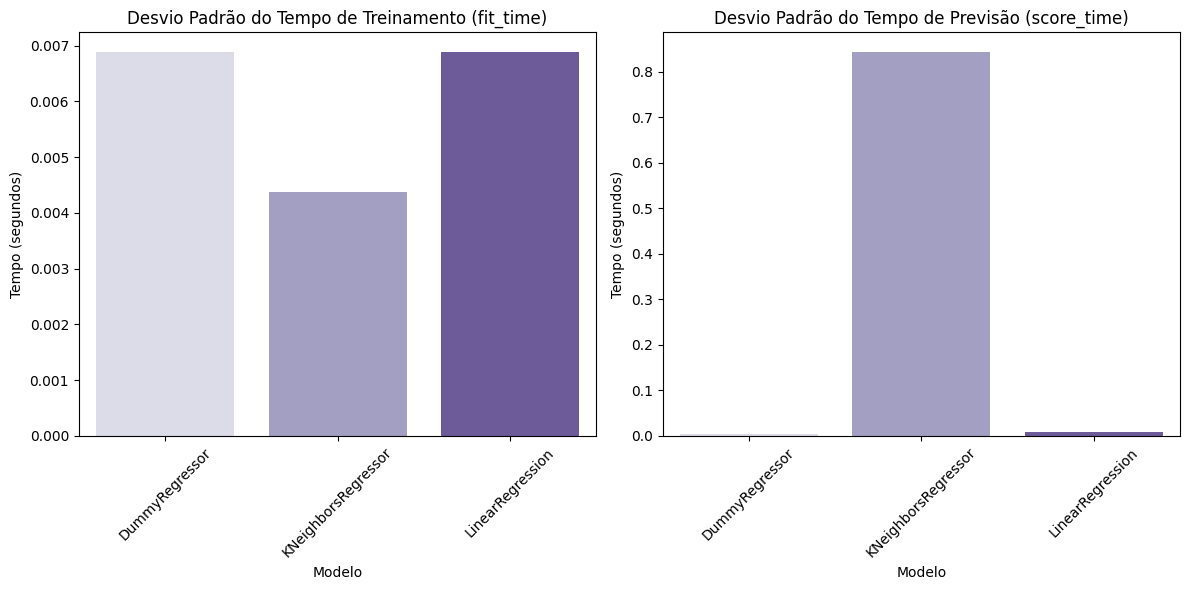

In [191]:
std_results = results_total.groupby('model').std().reset_index()

plt.figure(figsize=(12, 6))

# Tempo de treinamento (fit_time) - desvio padrão
plt.subplot(1, 2, 1)
sns.barplot(data=std_results, x='model', y='fit_time', palette='Purples')
plt.title('Desvio Padrão do Tempo de Treinamento (fit_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

# Tempo de previsão (score_time) - desvio padrão
plt.subplot(1, 2, 2)
sns.barplot(data=std_results, x='model', y='score_time', palette='Purples')
plt.title('Desvio Padrão do Tempo de Previsão (score_time)')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Modelo')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* Gráficos Comparativos para Métricas

## Predição do Modelo

PREDIÇÃO 1

* Divisão dos dados de Treinamento e Teste:

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [258]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [259]:
print("Shape of X_train_transformed:", X_train_transformed.shape)
print("Shape of X_test_transformed:", X_test_transformed.shape)

Shape of X_train_transformed: (19557, 15)
Shape of X_test_transformed: (4890, 15)


In [260]:
trained_models = {}
for model in modelos:
    model_name = type(model).__name__
    model.fit(X_train_transformed, y_train)
    trained_models[model_name] = model

In [261]:
predictions = {}
for model_name, trained_model in trained_models.items():
    y_pred = trained_model.predict(X_test_transformed)
    predictions[model_name] = y_pred
    print(f"Predictions for {model_name}:")
    print(y_pred[:5])  

Predictions for DummyRegressor:
[152.58413867 152.58413867 152.58413867 152.58413867 152.58413867]
Predictions for LinearRegression:
[122.65744643 155.28997332 187.74274766  62.71583056  62.54609433]
Predictions for KNeighborsRegressor:
[ 87.4  97.  193.8  73.8  65.4]


PREDIÇÃO 2

In [262]:
registro_exemplo = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

In [263]:
registro_df = pd.DataFrame([registro_exemplo])

In [264]:
registro_transformed = preprocessor.transform(registro_df)

In [265]:
for model_name, trained_model in trained_models.items():
    y_pred = trained_model.predict(registro_transformed)
    print(f"Predição de preço para {model_name}: {y_pred[0]:.2f}")

Predição de preço para DummyRegressor: 152.58
Predição de preço para LinearRegression: 276.51
Predição de preço para KNeighborsRegressor: 346.20
